# Numerically Integrating the SHO model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
x0 = 1.0 ## Initial position
v0 = 0.0 ## Initial velocity

omega = 2 ## Angular freq. of SHO

tf = 5 ## Model time

In [3]:
def AnalyticalSolutionSHO(tf, deltat, amp, omega, t0 = 0, phase = 0):
    
    if t0 < tf:
        
        t = np.arange(t0,tf,deltat) ## equal steps
        x = amp*np.cos(omega*t+phase)
        
        return t,x
    
    else:
        
        raise ValueError('Final time is before start time.')

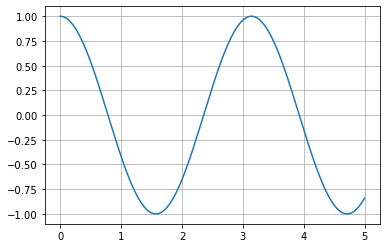

In [4]:
deltat = 0.001
t,x = AnalyticalSolutionSHO(tf, deltat, x0, omega)
plt.plot(t,x)
plt.grid()

$$\ddot{x} = -\omega x$$
$$\dfrac{d^2x}{dt^2} = -\omega x$$

Introduce $u=\dot{x}$, so that $\dot{u}=\ddot{x}$. We can produce two coupled, linear, first order, ODEs:

$$\dot{u} = -\omega x$$
$$\dot{x} = u$$

Imagine we allow ourselves to take a small step in time $\Delta t$, how would $u$ and $x$ change in that time?

$$\dot{x} = \dfrac{dx}{dt} = \lim_{\Delta t \rightarrow 0} \dfrac{x(t+\Delta t) - x(t)}{\Delta t} = u$$

So that,

$$x(t+\Delta t) \approx u\Delta t + x(t)$$
Similarly,
$$u(t+\Delta t) \approx -\omega x \Delta t + u(t)$$

## Developing a Numerical Routine

Notice we have two equations that describe how to obtain new values of location ($x$) and velocity ($u$) at a time $t+\Delta t$ given information about the system at some earlier time, $t$, (or at the least, considering the location and velocity at time $t$), which we take as a pair of **update equations** where the equality holds:

$$x(t+\Delta t) = u\Delta t + x(t)$$
$$u(t+\Delta t) = -\omega x \Delta t + u(t)$$

That is, they can potentially tell us at least in a short time $\Delta t$ that we can estimate the velocity ($u$) and location ($x$) of the oscillator. *We have not shown these can be used repeatedly to produce an estimated trajectory yet.* As you might expect, these are better update equations when $\Delta t$ is small. But there's another ambiguity:

$$x(t+\Delta t) = \underbrace{u}_{\mathtt{?}}\Delta t + x(t)$$
$$u(t+\Delta t) = -\omega \underbrace{x}_{\mathtt{?}} \Delta t + u(t)$$

The quantities with the underbrace are ambiguous. Do we use the values of $x$ and $u$ at a time $t$, $t+\Delta t$, or something else?!

### The choice matters

Let's illustrate this with making different choices using the following routine:

```{admonition} Basic ODE Integration Routine
```python
initialCond0 = VAL0
initialCond1 = VAL1
...
initialCondN = VALN

startTime = START
stopTime = STOP
steps =  STEPS
deltaT = (stopTime-startTime)/steps

t = startTime

while t < stopTime:

    updatedVal0 = updateEqn0()
    updatedVal1 = updateEqn1()
    ...
    updatedValN = updateEqnN()
    
    store(updatedVals)
    
    t += deltaT
```
```

This might seem quite abstract, so let's make a table of choices for our integration routines:

| Approach | Value of x      | Value of u      | Considerations                                                               |
|----------|-----------------|-----------------|------------------------------------------------------------------------------|
| 1        | $x(t)$          | $u(t)$          | We have both of these values to start                                        |
| 2        | $x(t)$          | $u(t+\Delta t)$ | For this, we will need a $u(t+\Delta t)$ estimate first                      |
| 3        | $x(t+\Delta t)$ | $u(t)$          | Hmm...we will need a $x(t+\Delta t)$ estimate first                          |
| 4        | $x(t+\Delta t)$ | $u(t+\Delta t)$ | Well this doesn't seem possible to get both estimates at the same time!      |


It looks like we can try approach 1, 2, and 3 without much fuss. Let's write a few functions.

In [5]:
N = int(np.ceil(tf/deltat))
steps = np.arange(0, N-1)
deltaT = tf/N
time = np.linspace(0,tf,N)

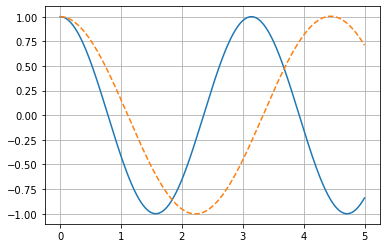

In [6]:
##Approach 1
xVals1 = np.zeros(N)
uVals1 = np.zeros(N)

xVals1[0] = x0
uVals1[0] = v0

for i in steps:
    
    uVals1[i+1] = uVals1[i] + xVals1[i]*deltaT
    xVals1[i+1] = xVals1[i] - omega*uVals1[i]*deltaT

plt.plot(t, x)
plt.plot(time, xVals1, '--')
plt.grid()

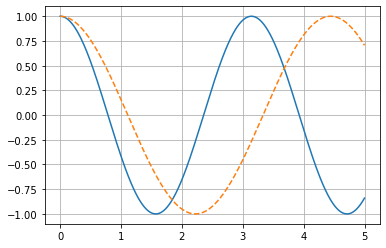

In [7]:
## Approach 2

xVals2 = np.zeros(N)
uVals2 = np.zeros(N)

xVals2[0] = x0
uVals2[0] = v0

for i in steps:
    
    uVals2[i+1] = uVals2[i] + xVals2[i]*deltaT
    xVals2[i+1] = xVals2[i] - omega*uVals2[i+1]*deltaT

plt.plot(t, x)
plt.plot(time, xVals2, '--')
plt.grid()

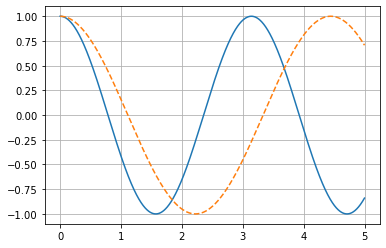

In [8]:
## Approach 3

xVals3 = np.zeros(N)
uVals3 = np.zeros(N)

xVals3[0] = x0
uVals3[0] = v0

for i in steps:
    
    xVals3[i+1] = xVals3[i] - omega*uVals3[i]*deltaT
    uVals3[i+1] = uVals3[i] + xVals3[i+1]*deltaT

plt.plot(t, x)
plt.plot(time, xVals3, '--')
plt.grid()

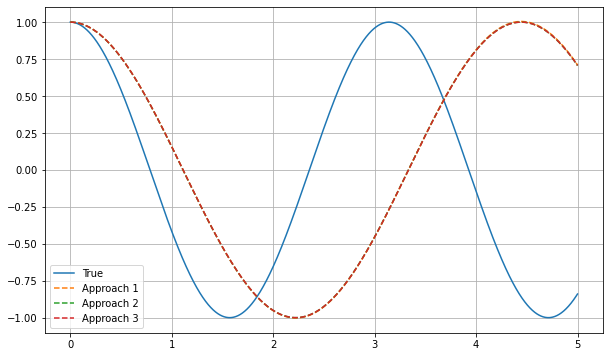

In [9]:
plt.figure(figsize=(10,6))
plt.plot(t, x)
plt.plot(time, xVals1, '--')
plt.plot(time, xVals2, '--')
plt.plot(time, xVals3, '--')
plt.legend(['True', 'Approach 1', 'Approach 2', 'Approach 3'])
plt.grid()

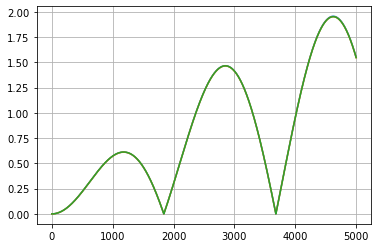

In [10]:
plt.plot(np.abs(x-xVals1))
plt.plot(np.abs(x-xVals2))
plt.plot(np.abs(x-xVals3))
plt.grid()

In [11]:
from scipy.integrate import odeint

In [12]:
def NumericalSolutionSHO(y, t, omega):
    
    x, vx = y
    dydt = [vx, -omega*x]
    return dydt

In [13]:
omega0 = omega
y0 = [x0, v0]
t = time
sol = odeint(NumericalSolutionSHO, y0, t, args=(omega0,))

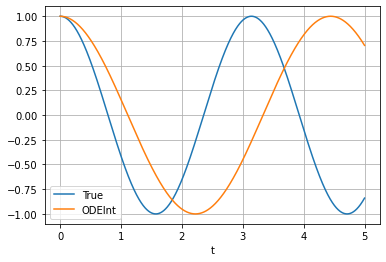

In [14]:
plt.plot(t, x, label='True')
plt.plot(t, sol[:,0], label='ODEInt')
plt.legend(loc='best')

plt.xlabel('t')

plt.grid()